In [1]:
def geography(left, right, bottom, top, resolution=12):
    """
    指定された緯度・経度範囲を基に、データグリッドのインデックスを計算する関数。
    """
    upperindex = int((90 - top) * resolution)
    lowerindex = int((90 - bottom) * resolution)
    leftindex = int((180 + left) * resolution)
    rightindex = int((180 + right) * resolution)

    rgnshape = (lowerindex - upperindex, rightindex - leftindex)
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent

In [2]:
import os
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfea
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

city_num = 15
left, right, bottom, top = 23, 34, 37, 44
upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
mask_path = f'{h08dir}/camacity/dat/cty_msk_/city_clrd0000.gl5'
mask = np.fromfile(mask_path, dtype='float32').reshape(2160, 4320) 
mask_cropped = mask[upperindex:lowerindex, leftindex:rightindex]
mask_cropped = np.where(mask_cropped==city_num, 1, 0)

In [3]:
def draw_mask_sotowaku(left,right, bottom, top, mask_cropped, ax=None, sotowaku_color='black', inner_color='black', linewidth=3):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    zorder = 2: 白色の内枠が最前面(citymask)
    """

    # delta
    delta = 360/4320
    x_left = left
    y_top = top
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows):
        for j in range(cols):
            if mask_cropped[i, j] == 1:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    if ax is None:
        # figure
        fig = plt.figure(figsize=(5,5))
        ax = plt.subplot(projection=projection)
        ax.coastlines(zorder=1)
        ax.set_extent([left, right, bottom, top])
        ax.gridlines(draw_labels=True, zorder=0)
        ax.add_feature(cfea.OCEAN, color='#BBBBBB')
        ax.add_feature(cfea.LAKES, color='#BBBBBB')
        leftlim, rightlim, bottomlim, toplim = left+1.5, right-1.5, bottom+1.5, top-1.5
        ax.set_xlim(leftlim, rightlim)
        ax.set_ylim(bottomlim, toplim)
        
    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=inner_color, transform=projection, linewidth=linewidth-2, zorder=2) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=inner_color, transform=projection, linewidth=linewidth-2, zorder=2) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=inner_color, transform=projection, linewidth=linewidth-2, zorder=2) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=inner_color, transform=projection, linewidth=linewidth-2, zorder=2) # right

    if ax is None:
        plt.show()
    else:
        return ax

CPU times: user 97.4 ms, sys: 10.1 ms, total: 107 ms
Wall time: 117 ms


<GeoAxes: >

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


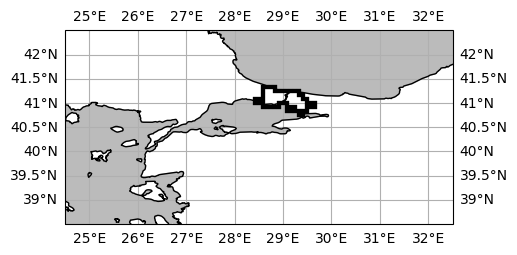

In [4]:
%time draw_mask_sotowaku(left, right, bottom, top, mask_cropped, ax=None, sotowaku_color='black', inner_color='black', linewidth=3)

In [5]:
def nxtl2nxtxy(rivnxl, 
               upperindex, lowerindex, leftindex, rightindex, 
               a=2160, b=4320, nan_value = 1e20):
    # region
    rivnxl_cropped = rivnxl[upperindex:lowerindex, leftindex:rightindex]
    H, W = rivnxl_cropped.shape
    rivnxl_cropped[rivnxl_cropped < 10] = np.nan

    # L -> (y, x)
    mask = ~np.isnan(rivnxl_cropped)
    riv_flat = rivnxl_cropped[mask].astype(int) # 1次元に変換
    lat_l = (riv_flat - 1)  // b
    lon_l = (riv_flat - 1) % b
    lat_l = lat_l.astype(float)
    lon_l = lon_l.astype(float)

    # offset
    lat_l -= upperindex
    lon_l -= leftindex

    # 範囲外のセルをNaNにする
    out_of_bounds_mask = (lat_l < 0) | (lat_l >= H) | (lon_l < 0) | (lon_l >= W)
    lat_l[out_of_bounds_mask] = nan_value
    lon_l[out_of_bounds_mask] = nan_value

    # (y, x)座標ペアとして格納
    riv_nxtxy_cropped  = np.full((*rivnxl_cropped.shape, 2), np.nan, dtype=float) # 初期化
    riv_nxtxy_cropped[mask] = np.column_stack((lat_l, lon_l)) # (N, 2)のデータを挿入

    return riv_nxtxy_cropped.astype(int)
    
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
# rivnextlonlat 
rivnxl_path = f"{h08dir}/global_city/dat/riv_nxl_/rivnxl.CAMA.gl5"
rivnxl_gl5 = np.fromfile(rivnxl_path, 'float32').reshape(2160, 4320)
%time riv_nxtxy_cropped = nxtl2nxtxy(rivnxl_gl5, upperindex, lowerindex, leftindex, rightindex)

CPU times: user 536 µs, sys: 190 µs, total: 726 µs
Wall time: 731 µs


/tmp/ipykernel_380/1272940717.py:30: RuntimeWarning: invalid value encountered in cast
  return riv_nxtxy_cropped.astype(int)


In [6]:
def plot_cropped_river_network(riv_nxtxy_cropped, left, right, bottom, top,
                               projection=ccrs.PlateCarree(),
                               line_color='blue', line_width=1.0, a=2160, b=4320):
    mask = ~np.isnan(riv_nxtxy_cropped[..., 0])
    from_y, from_x = np.where(mask)

    to_y, to_x = riv_nxtxy_cropped[mask][:, 0], riv_nxtxy_cropped[mask][:, 1]

    #valid_mask = (to_y >= 0) & (to_x >= 0)
    #from_y, from_x = from_y[valid_mask], from_x[valid_mask]
    #to_y, to_x = to_y[valid_mask], to_x[valid_mask]

    # 緯度経度に変換
    lat_res = 180.0 / a
    lon_res = 360.0 / b

    lats_from = top - (from_y + 0.5) * lat_res
    lats_to = top - (to_y + 0.5) * lat_res
    lons_from = left + (from_x + 0.5) * lon_res
    lons_to = left + (to_x + 0.5) * lon_res

    # 河川ネットワークの線分リスト
    points_from = np.column_stack([lons_from, lats_from])
    points_to = np.column_stack([lons_to, lats_to])
    segments = np.stack([points_from, points_to], axis=1)

    # Cartopy を用いた描画
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], crs=projection)

    # 河川を描画
    lc = LineCollection(segments, colors=line_color, linewidths=line_width, transform=ccrs.PlateCarree())
    ax.add_collection(lc)

    # 地図の補助情報
    ax.coastlines()
    ax.gridlines(draw_labels=True, linestyle="dotted", linewidth=0)

    leftlim, rightlim, bottomlim, toplim = left+1.5, right-1.5, bottom+1.5, top-1.5
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

    plt.show()

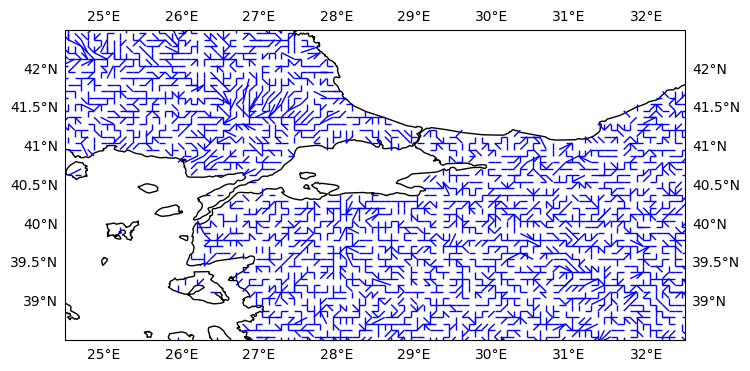

CPU times: user 3.14 s, sys: 343 ms, total: 3.48 s
Wall time: 3.1 s


In [7]:
%time plot_cropped_river_network(riv_nxtxy_cropped, left, right, bottom, top)

In [8]:
# discharge
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
rivout = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
rivout_cropped = rivout[upperindex:lowerindex, leftindex:rightindex] * 60 * 60 * 24 * 365 / 1000 # m3/year

def plot_cropped_river_network_discharge(riv_nxtxy_cropped, rivout_cropped,
                                         left, right, bottom, top,
                                         projection=ccrs.PlateCarree(),
                                         line_color='blue', min_width=0.1, max_width=2.5, 
                                         a=2160, b=4320):
    mask = ~np.isnan(riv_nxtxy_cropped[..., 0])
    from_y, from_x = np.where(mask)

    to_y, to_x = riv_nxtxy_cropped[mask][:, 0], riv_nxtxy_cropped[mask][:, 1]

    # 緯度経度に変換
    lat_res = 180.0 / a
    lon_res = 360.0 / b

    lats_from = top - (from_y + 0.5) * lat_res
    lats_to = top - (to_y + 0.5) * lat_res
    lons_from = left + (from_x + 0.5) * lon_res
    lons_to = left + (to_x + 0.5) * lon_res

    # 流量によって線の太さを決定
    inflow_values = rivout_cropped[from_y, from_x]
    linewidths = np.interp(inflow_values, (inflow_values.min(), inflow_values.max()), (min_width, max_width))

    # 河川ネットワークの線分リスト
    points_from = np.column_stack([lons_from, lats_from])
    points_to = np.column_stack([lons_to, lats_to])
    segments = np.stack([points_from, points_to], axis=1)

    # Cartopy を用いた描画
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], crs=projection)

    # 河川を描画
    lc = LineCollection(segments, colors=line_color, linewidths=linewidths, transform=ccrs.PlateCarree())
    ax.add_collection(lc)

    # 地図の補助情報
    ax.coastlines()
    ax.gridlines(draw_labels=True, linestyle="dotted", linewidth=0)

    leftlim, rightlim, bottomlim, toplim = left+1.5, right-1.5, bottom+1.5, top-1.5
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

    plt.show()

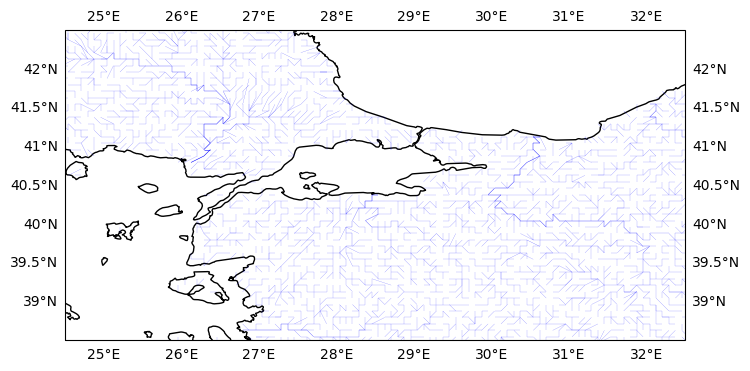

CPU times: user 3.3 s, sys: 315 ms, total: 3.61 s
Wall time: 3.23 s


In [9]:
%time plot_cropped_river_network_discharge(riv_nxtxy_cropped, rivout_cropped, left, right, bottom, top, max_width=5)

In [10]:
# rivnum
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320) 
rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]

def plot_cropped_river_network_discharge_basin(riv_nxtxy_cropped, rivout_cropped, rivnum_cropped,
                                           left, right, bottom, top,
                                           projection=ccrs.PlateCarree(),
                                           line_color='blue', min_width=0.1, max_width=2.5, 
                                           a=2160, b=4320, min_basin_size=10):

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], crs=projection)

    H, W = rivnum_cropped.shape
    lat_res = 180.0 / a
    lon_res = 360.0 / b

    # **流域ごとのグリッド数をカウント**
    rivnum_filtered = rivnum_cropped.copy()
    rivnum_filtered[rivnum_filtered == 0] = np.nan
    unique_basins, counts = np.unique(rivnum_filtered[~np.isnan(rivnum_filtered)], return_counts=True)

    # **10グリッド以下の流域をNaNにする**
    small_basins = unique_basins[counts <= min_basin_size]  # 小さい流域番号
    basin_mask = np.isin(rivnum_filtered, small_basins)  # 小さい流域のマスク
    rivnum_filtered[basin_mask] = np.nan  # 10グリッド以下の流域をNaNにする

    # **流域ごとに色を設定**
    unique_basins_filtered = np.unique(rivnum_filtered[~np.isnan(rivnum_filtered)])
    cmap = plt.cm.get_cmap("tab20", len(unique_basins_filtered))  # 最大20色
    norm = mcolors.BoundaryNorm(unique_basins_filtered, cmap.N)  # 流域番号を正規化

    # **流域マップの描画**
    lats = np.linspace(top, bottom, H + 1)
    lons = np.linspace(left, right, W + 1)
    mesh = ax.pcolormesh(lons, lats, rivnum_filtered, cmap=cmap, norm=norm, shading='auto', transform=ccrs.PlateCarree(), alpha=0.5)

    # **河川ネットワークの描画**
    mask = ~np.isnan(riv_nxtxy_cropped[..., 0])
    from_y, from_x = np.where(mask)
    to_y, to_x = riv_nxtxy_cropped[mask][:, 0], riv_nxtxy_cropped[mask][:, 1]

    valid_mask = (to_y >= 0) & (to_x >= 0)
    from_y, from_x = from_y[valid_mask], from_x[valid_mask]
    to_y, to_x = to_y[valid_mask], to_x[valid_mask]

    # 河川ごとの流量
    inflow_values = rivout_cropped[from_y, from_x]
    linewidths = np.interp(inflow_values, (inflow_values.min(), inflow_values.max()), (min_width, max_width))

    # 緯度経度に変換
    lats_from = top - (from_y + 0.5) * lat_res
    lats_to = top - (to_y + 0.5) * lat_res
    lons_from = left + (from_x + 0.5) * lon_res
    lons_to = left + (to_x + 0.5) * lon_res

    points_from = np.column_stack([lons_from, lats_from])
    points_to = np.column_stack([lons_to, lats_to])
    segments = np.stack([points_from, points_to], axis=1)

    lc = LineCollection(segments, colors=line_color, linewidths=linewidths, transform=ccrs.PlateCarree())
    ax.add_collection(lc)

    # 地図の補助情報
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0)

    leftlim, rightlim, bottomlim, toplim = left+1.5, right-1.5, bottom+1.5, top-1.5
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

    plt.show()


/tmp/ipykernel_380/1759709434.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_basins_filtered))  # 最大20色


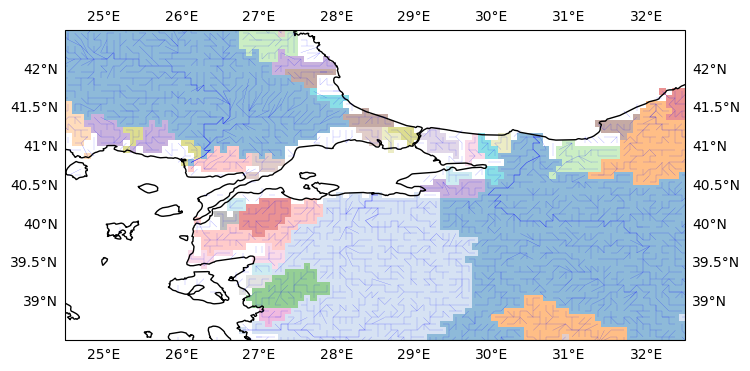

CPU times: user 512 ms, sys: 286 ms, total: 798 ms
Wall time: 418 ms


In [11]:
%time plot_cropped_river_network_discharge_basin(riv_nxtxy_cropped, rivout_cropped, rivnum_cropped, left, right, bottom, top, min_basin_size=5, max_width=5)

In [12]:
def plot_riverend(riv_nxtxy_cropped, rivout_cropped, rivnum_cropped,
                   left, right, bottom, top,
                   projection=ccrs.PlateCarree(),
                   line_color='blue', min_width=0.1, max_width=2.5, 
                   a=2160, b=4320, min_basin_size=5, end_marker_color='white'):

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], crs=projection)

    H, W = rivnum_cropped.shape
    lat_res = 180.0 / a
    lon_res = 360.0 / b

    # **流域ごとのグリッド数をカウント**
    rivnum_filtered = rivnum_cropped.copy()
    rivnum_filtered[rivnum_filtered == 0] = np.nan
    unique_basins, counts = np.unique(rivnum_filtered[~np.isnan(rivnum_filtered)], return_counts=True)

    # **10グリッド以下の流域をNaNにする**
    small_basins = unique_basins[counts <= min_basin_size]  # 小さい流域番号
    basin_mask = np.isin(rivnum_filtered, small_basins)  # 小さい流域のマスク
    rivnum_filtered[basin_mask] = np.nan  # 10グリッド以下の流域をNaNにする

    # **流域ごとに色を設定**
    unique_basins_filtered = np.unique(rivnum_filtered[~np.isnan(rivnum_filtered)])
    cmap = plt.cm.get_cmap("tab20", len(unique_basins_filtered))  # 最大20色
    norm = mcolors.BoundaryNorm(unique_basins_filtered, cmap.N)  # 流域番号を正規化

    # **流域マップの描画**
    lats = np.linspace(top, bottom, H + 1)
    lons = np.linspace(left, right, W + 1)
    mesh = ax.pcolormesh(lons, lats, rivnum_filtered, cmap=cmap, norm=norm, shading='auto', transform=ccrs.PlateCarree(), alpha=0.5)

    # **河川ネットワークの描画**
    mask = ~np.isnan(riv_nxtxy_cropped[..., 0])
    from_y, from_x = np.where(mask)
    to_y, to_x = riv_nxtxy_cropped[mask][:, 0], riv_nxtxy_cropped[mask][:, 1]

    valid_mask = (to_y >= 0) & (to_x >= 0)
    from_y, from_x = from_y[valid_mask], from_x[valid_mask]
    to_y, to_x = to_y[valid_mask], to_x[valid_mask]

    # 河川ごとの流量
    inflow_values = rivout_cropped[from_y, from_x]
    linewidths = np.interp(inflow_values, (inflow_values.min(), inflow_values.max()), (min_width, max_width))

    # 河川の終点
    end_mask = (np.isnan(to_y)) | (np.isnan(to_x)) | ((from_y == to_y) & (from_x == to_x))
    end_y, end_x = from_y[end_mask], from_x[end_mask]  # 終点の座標
    valid_end_mask = ~np.isnan(rivnum_filtered[end_y, end_x])  # 小さい流域の終点を除外
    end_y, end_x = end_y[valid_end_mask], end_x[valid_end_mask]  # フィルタ適用
    end_lats = top - (end_y + 0.5) * lat_res
    end_lons = left + (end_x + 0.5) * lon_res

    # 緯度経度に変換
    lats_from = top - (from_y + 0.5) * lat_res
    lats_to = top - (to_y + 0.5) * lat_res
    lons_from = left + (from_x + 0.5) * lon_res
    lons_to = left + (to_x + 0.5) * lon_res

    points_from = np.column_stack([lons_from, lats_from])
    points_to = np.column_stack([lons_to, lats_to])
    segments = np.stack([points_from, points_to], axis=1)

    lc = LineCollection(segments, colors=line_color, linewidths=linewidths, transform=ccrs.PlateCarree())
    ax.add_collection(lc)
    
    # **河川の終点に〇マークを描写**
    ax.scatter(end_lons, end_lats, color=end_marker_color, s=10, edgecolors='black', transform=ccrs.PlateCarree())

    # 地図の補助情報
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0)

    leftlim, rightlim, bottomlim, toplim = left+1.5, right-1.5, bottom+1.5, top-1.5
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

    plt.show()

/tmp/ipykernel_380/3170041293.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_basins_filtered))  # 最大20色


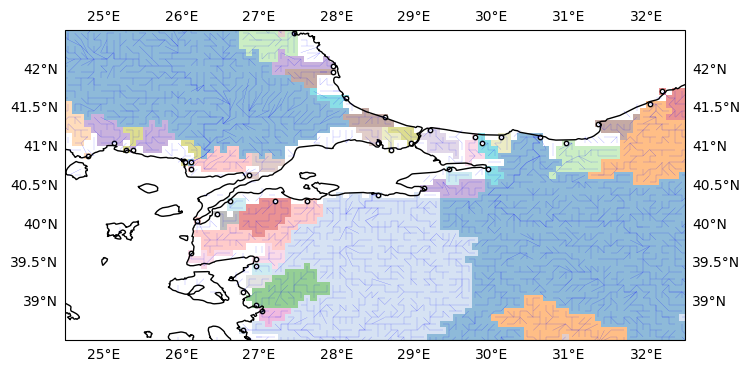

CPU times: user 444 ms, sys: 368 ms, total: 811 ms
Wall time: 433 ms


In [13]:
%time plot_riverend(riv_nxtxy_cropped, rivout_cropped, rivnum_cropped, left, right, bottom, top, min_basin_size=5)

In [14]:
def plot_river_city(city_cropped,
                    riv_nxtxy_cropped, rivout_cropped, rivnum_cropped,
                    left, right, bottom, top,
                    projection=ccrs.PlateCarree(),
                    line_color='blue', min_width=0.1, max_width=2.5, 
                    a=2160, b=4320, min_basin_size=5, end_marker_color='white'):

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], crs=projection)

    H, W = rivnum_cropped.shape
    lat_res = 180.0 / a
    lon_res = 360.0 / b

    # **流域ごとのグリッド数をカウント**
    rivnum_filtered = rivnum_cropped.copy()
    rivnum_filtered[rivnum_filtered == 0] = np.nan
    unique_basins, counts = np.unique(rivnum_filtered[~np.isnan(rivnum_filtered)], return_counts=True)

    # **10グリッド以下の流域をNaNにする**
    small_basins = unique_basins[counts <= min_basin_size]  # 小さい流域番号
    basin_mask = np.isin(rivnum_filtered, small_basins)  # 小さい流域のマスク
    rivnum_filtered[basin_mask] = np.nan  # 10グリッド以下の流域をNaNにする

    # **流域ごとに色を設定**
    unique_basins_filtered = np.unique(rivnum_filtered[~np.isnan(rivnum_filtered)])
    cmap = plt.cm.get_cmap("tab20", len(unique_basins_filtered))  # 最大20色
    norm = mcolors.BoundaryNorm(unique_basins_filtered, cmap.N)  # 流域番号を正規化

    # **流域マップの描画**
    lats = np.linspace(top, bottom, H + 1)
    lons = np.linspace(left, right, W + 1)
    mesh = ax.pcolormesh(lons, lats, rivnum_filtered, cmap=cmap, norm=norm, shading='auto', transform=ccrs.PlateCarree(), alpha=0.5)

    # **河川ネットワークの描画**
    mask = ~np.isnan(riv_nxtxy_cropped[..., 0])
    from_y, from_x = np.where(mask)
    to_y, to_x = riv_nxtxy_cropped[mask][:, 0], riv_nxtxy_cropped[mask][:, 1]

    valid_mask = (to_y >= 0) & (to_x >= 0)
    from_y, from_x = from_y[valid_mask], from_x[valid_mask]
    to_y, to_x = to_y[valid_mask], to_x[valid_mask]

    # 河川ごとの流量
    inflow_values = rivout_cropped[from_y, from_x]
    linewidths = np.interp(inflow_values, (inflow_values.min(), inflow_values.max()), (min_width, max_width))

    # 河川の終点
    end_mask = (np.isnan(to_y)) | (np.isnan(to_x)) | ((from_y == to_y) & (from_x == to_x))
    end_y, end_x = from_y[end_mask], from_x[end_mask]  # 終点の座標
    valid_end_mask = ~np.isnan(rivnum_filtered[end_y, end_x])  # 小さい流域の終点を除外
    end_y, end_x = end_y[valid_end_mask], end_x[valid_end_mask]  # フィルタ適用
    end_lats = top - (end_y + 0.5) * lat_res
    end_lons = left + (end_x + 0.5) * lon_res

    # 緯度経度に変換
    lats_from = top - (from_y + 0.5) * lat_res
    lats_to = top - (to_y + 0.5) * lat_res
    lons_from = left + (from_x + 0.5) * lon_res
    lons_to = left + (to_x + 0.5) * lon_res

    points_from = np.column_stack([lons_from, lats_from])
    points_to = np.column_stack([lons_to, lats_to])
    segments = np.stack([points_from, points_to], axis=1)

    lc = LineCollection(segments, colors=line_color, linewidths=linewidths, transform=ccrs.PlateCarree())
    ax.add_collection(lc)
    
    # **河川の終点に〇マークを描写**
    ax.scatter(end_lons, end_lats, color=end_marker_color, s=10, edgecolors='black', transform=ccrs.PlateCarree())

    # city mask
    draw_mask_sotowaku(left, right, bottom, top, city_cropped, ax=ax, sotowaku_color='red', inner_color='red', linewidth=1)

    # 地図の補助情報
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0)

    leftlim, rightlim, bottomlim, toplim = left+1.5, right-1.5, bottom+1.5, top-1.5
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

    plt.show()

/tmp/ipykernel_380/1948715033.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_basins_filtered))  # 最大20色


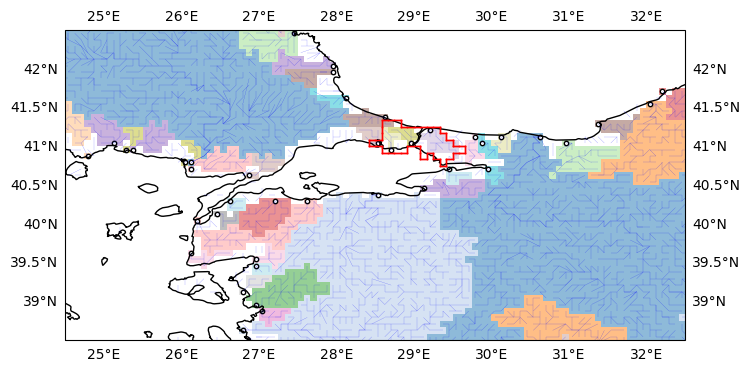

CPU times: user 536 ms, sys: 322 ms, total: 858 ms
Wall time: 476 ms


In [15]:
%time plot_river_city(mask_cropped, riv_nxtxy_cropped, rivout_cropped, rivnum_cropped, left, right, bottom, top, min_basin_size=5)

In [179]:
# 50l Domestic level1
# 100l Domestic level2 
# 293l All needs, level1
# 406l All needs, level2

# population
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
poptot_path = f'{h08dir}/global_city/dat/pop_tot_/GPW4ag__20100000.gl5'
poptot = np.fromfile(poptot_path, dtype='float32').reshape(2160, 4320) 
poptot_cropped = poptot[upperindex:lowerindex, leftindex:rightindex]

# city population
city_pop = np.sum(poptot_cropped[mask_cropped==1])

# liter/capita/day
availability = ((rivout_cropped*1000) / (365)) / city_pop

def first_availability(city_cropped,
                    riv_nxtxy_cropped, rivout_cropped, rivnum_cropped,
                    availability,
                    left, right, bottom, top,
                    projection=ccrs.PlateCarree(),
                    line_color='blue', min_width=0.1, max_width=2.5, 
                    a=2160, b=4320, min_basin_size=5, end_marker_color='white'):

    # general
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], crs=projection)

    # resoluation
    lat_res = 180.0 / a
    lon_res = 360.0 / b

    # **河川ネットワークの描画**
    mask = ~np.isnan(riv_nxtxy_cropped[..., 0])
    from_y, from_x = np.where(mask)
    to_y, to_x = riv_nxtxy_cropped[mask][:, 0], riv_nxtxy_cropped[mask][:, 1]

    valid_mask = (to_y >= 0) & (to_x >= 0)
    from_y, from_x = from_y[valid_mask], from_x[valid_mask]
    to_y, to_x = to_y[valid_mask], to_x[valid_mask]
    
    # **流域ごとのグリッド数をカウント**
    rivnum_filtered = rivnum_cropped.copy()
    rivnum_filtered[rivnum_filtered == 0] = np.nan
    unique_basins, counts = np.unique(rivnum_filtered[~np.isnan(rivnum_filtered)], return_counts=True)

    # **10グリッド以下の流域をNaNにする**
    small_basins = unique_basins[counts <= min_basin_size]  # 小さい流域番号
    basin_mask = np.isin(rivnum_filtered, small_basins)  # 小さい流域のマスク
    rivnum_filtered[basin_mask] = np.nan  # 10グリッド以下の流域をNaNにする

    # 河川ごとの流量
    inflow_values = rivout_cropped[from_y, from_x]
    linewidths = np.interp(inflow_values, (inflow_values.min(), inflow_values.max()), (min_width, max_width))

    # 河川の終点
    end_mask = (np.isnan(to_y)) | (np.isnan(to_x)) | ((from_y == to_y) & (from_x == to_x))
    end_y, end_x = from_y[end_mask], from_x[end_mask]  # 終点の座標
    valid_end_mask = ~np.isnan(rivnum_filtered[end_y, end_x])  # 小さい流域の終点を除外
    end_y, end_x = end_y[valid_end_mask], end_x[valid_end_mask]  # フィルタ適用
    end_lats = top - (end_y + 0.5) * lat_res
    end_lons = left + (end_x + 0.5) * lon_res

    # 緯度経度に変換
    lats_from = top - (from_y + 0.5) * lat_res
    lats_to = top - (to_y + 0.5) * lat_res
    lons_from = left + (from_x + 0.5) * lon_res
    lons_to = left + (to_x + 0.5) * lon_res

    points_from = np.column_stack([lons_from, lats_from])
    points_to = np.column_stack([lons_to, lats_to])
    segments = np.stack([points_from, points_to], axis=1)

    lc = LineCollection(segments, colors=line_color, linewidths=linewidths, transform=ccrs.PlateCarree())
    ax.add_collection(lc)
    
    # **河川の終点に〇マークを描写**
    ax.scatter(end_lons, end_lats, color=end_marker_color, s=10, edgecolors='black', transform=ccrs.PlateCarree())

    # **availability（可用性データ）の描写**
    label_list = [50, 100, 293, 406]
    cmap = ListedColormap(['white', 'salmon', 'sandybrown', 'khaki', 'lightgreen'])  # 5段階の色
    norm = BoundaryNorm([0] + label_list + [np.max(availability)], cmap.N)  # 境界設定

    im = ax.imshow(availability, 
                   cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), extent=[left, right, bottom, top])

    # カラーバーを追加
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', label='Availability(liter/day/capita)')
    cbar.set_ticks(label_list)  # カラーバーの目盛りを調整

    # city mask
    draw_mask_sotowaku(left, right, bottom, top, city_cropped, ax=ax, sotowaku_color='red', inner_color='red', linewidth=1)

    # 地図の補助情報
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0)

    leftlim, rightlim, bottomlim, toplim = left+1.5, right-1.5, bottom+1.5, top-1.5
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

    plt.show()

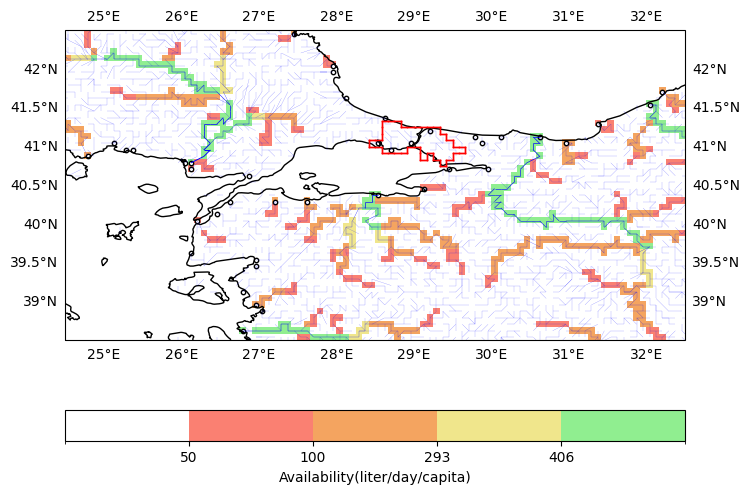

CPU times: user 610 ms, sys: 360 ms, total: 970 ms
Wall time: 552 ms


In [181]:
%time first_availability(mask_cropped, riv_nxtxy_cropped, rivout_cropped, rivnum_cropped, availability, left, right, bottom, top, max_width=10)

In [18]:
# rivara
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
rivara_path = f'{h08dir}/global_city/dat/riv_ara_/rivara.CAMA.gl5'
rivara = np.fromfile(rivara_path, dtype='float32').reshape(2160, 4320) 
rivara_cropped = rivara[upperindex:lowerindex, leftindex:rightindex]

def get_updown_mainriver(rivmou_coords, rivara_cropped, riv_nxtxy_cropped):
    
    # riv_nxtxy_croppedの中でmainriverである座標を保存
    mainriver_coords = {}
    for basin in rivmou_coords:
        yyy, xxx = map(int, rivmou_coords[basin])
        target_coord = (yyy, xxx)
        path_coords = [target_coord]
        visited_coords = set()

        while True:
            if target_coord in visited_coords:
                break
            visited_coords.add(target_coord)
            matched_coords = np.argwhere(
                np.all(target_coord == riv_nxtxy_cropped, axis=2)
            )
            if len(matched_coords) == 0:
                break
            unvisited_matched = [
                tuple(coord) for coord in matched_coords if tuple(coord) not in visited_coords
            ]
            if not unvisited_matched:
                break
            rivara_values = [
                rivara_cropped[coord[0], coord[1]] for coord in unvisited_matched
            ]
            max_index = np.argmax(rivara_values)
            best_coord = unvisited_matched[max_index]
            target_coord = best_coord
            path_coords.append(target_coord)
        mainriver_coords[basin] = path_coords

    return mainriver_coords

def plot_mainriver(city_cropped,
                   rivara_cropped, riv_nxtxy_cropped, rivout_cropped, rivnum_cropped,
                   left, right, bottom, top,
                   projection=ccrs.PlateCarree(),
                   line_color='blue', min_width=0.1, max_width=5.0, 
                   a=2160, b=4320, min_basin_size=5, end_marker_color='white'):

    # general
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], crs=projection)

    # resoluation
    lat_res = 180.0 / a
    lon_res = 360.0 / b

    # **流域ごとのグリッド数をカウント**
    rivnum_filtered = rivnum_cropped.copy()
    rivnum_filtered[rivnum_filtered == 0] = np.nan
    unique_basins, counts = np.unique(rivnum_filtered[~np.isnan(rivnum_filtered)], return_counts=True)

    # **10グリッド以下の流域をNaNにする**
    small_basins = unique_basins[counts <= min_basin_size]  # 小さい流域番号
    basin_mask = np.isin(rivnum_filtered, small_basins)  # 小さい流域のマスク
    rivnum_filtered[basin_mask] = np.nan  # 10グリッド以下の流域をNaNにする

    # 各rivnumにおけるrivaraの最大値のcoordを取得する 
    rivmou_coords = {}
    unique_basins_filtered = np.unique(rivnum_filtered[~np.isnan(rivnum_filtered)])
    for basin in unique_basins_filtered:
        basin_mask = rivnum_filtered == basin
        max_idx = np.unravel_index(np.argmax(rivara_cropped * basin_mask), rivara_cropped.shape)
        rivmou_coords[basin] = max_idx

    # 上流の主河道を探索
    mainriver_coords = get_updown_mainriver(rivmou_coords, rivara_cropped, riv_nxtxy_cropped)

    # maskを作成
    mainriver_mask = np.zeros(rivnum_cropped.shape)
    for path in mainriver_coords.values():
        for y, x in path:
            mainriver_mask[y, x] = 1

    # **河川ネットワークの描画（mainriver_mask に基づく）**
    mask = (~np.isnan(riv_nxtxy_cropped[..., 0])) & (mainriver_mask > 0)
    from_y, from_x = np.where(mask)
    to_y, to_x = riv_nxtxy_cropped[mask][:, 0], riv_nxtxy_cropped[mask][:, 1]
    
    # 無効な座標を除外
    valid_mask = (to_y >= 0) & (to_x >= 0)
    from_y, from_x = from_y[valid_mask], from_x[valid_mask]
    to_y, to_x = to_y[valid_mask], to_x[valid_mask]
    
    # 河川ごとの流量 (無効な座標の処理の後に必ず行う)
    inflow_values = rivout_cropped[from_y, from_x]
    linewidths = np.interp(
        inflow_values,
        (np.nanmin(inflow_values), np.nanmax(inflow_values)),  # NaN を除いて最小・最大を取得
        (min_width, max_width)
    )
    
    # 緯度経度に変換
    lats_from = top - (from_y + 0.5) * lat_res
    lats_to = top - (to_y + 0.5) * lat_res
    lons_from = left + (from_x + 0.5) * lon_res
    lons_to = left + (to_x + 0.5) * lon_res
    points_from = np.column_stack([lons_from, lats_from])
    points_to = np.column_stack([lons_to, lats_to])
    segments = np.stack([points_from, points_to], axis=1)

    # 河川網描写
    lc = LineCollection(segments, colors=line_color, linewidths=linewidths, transform=ccrs.PlateCarree())
    ax.add_collection(lc)

    # city mask
    draw_mask_sotowaku(left, right, bottom, top, city_cropped, ax=ax, sotowaku_color='red', inner_color='red', linewidth=1)

    # 地図の補助情報
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0)

    leftlim, rightlim, bottomlim, toplim = left+1.5, right-1.5, bottom+1.5, top-1.5
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

    plt.show()

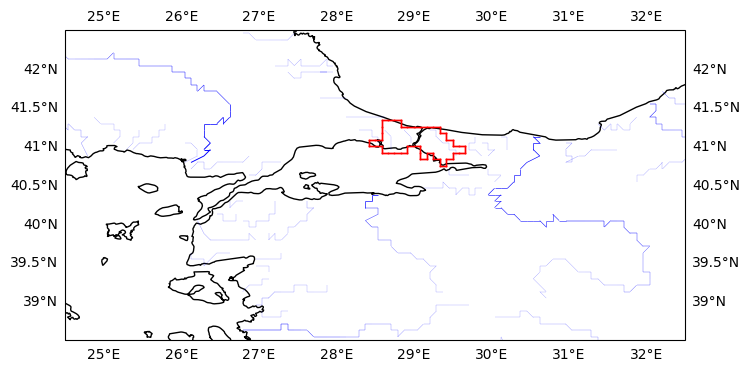

CPU times: user 658 ms, sys: 283 ms, total: 941 ms
Wall time: 630 ms


In [19]:
%time plot_mainriver(mask_cropped, rivara_cropped, riv_nxtxy_cropped, rivout_cropped, rivnum_cropped, left, right, bottom, top, max_width=10)

In [20]:
#---------------------------------------------------------------------------------------------------------------
#  流域4色塗分け問題
#---------------------------------------------------------------------------------------------------------------
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import pulp
from ortoolpy import model_min, addbinvars, addvals
from pulp import lpSum

def get_unique_non_masked_values(values):
    result = []
    for value in np.unique(values):
        if value is not np.ma.masked and not np.isnan(value):
            result.append(value)
    result = [x for x in result if x != -1.0]
    return result

def get_adjacent(arr, basin_num):
    neighbors = []
    rows, cols = arr.shape
    directions = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
    for row in range(rows):
        for col in range(cols):
            if int(arr[row, col]) == int(basin_num):
                for dr, dc in directions:
                    r, c = row + dr, col + dc
                    if 0 <= r < rows and 0 <= c < cols:
                        if int(arr[r,c]) != int(basin_num):
                            neighbors.append(int(arr[r, c]))
                        
    unique_neighbors = get_unique_non_masked_values(neighbors)
    return unique_neighbors

def four_color_problem(Rivnum_masked_array, color_code):
    basin_lst = get_unique_non_masked_values(Rivnum_masked_array)
    
    # make data
    df = pd.DataFrame([
    (i, int(basin_lst[i]), j) 
    for i in range(len(basin_lst)) 
    for j in range(len(color_code))
    ], columns=['code', 'basin_num', 'color'])
    
    # optimization
    m = model_min()  # 数理モデル(1)
    addbinvars(df)  # 変数表(2)
    for i in range(len(basin_lst)):
        m += lpSum(df[df.code == i].Var) == 1  # 1県1色(3)
        for j in get_adjacent(Rivnum_masked_array, int(basin_lst[i])):
            for k in range(len(color_code)):  # 隣接県を違う色に(4)
                m += lpSum(df[((df.code == i)  | (df.basin_num == int(j))) & (df.color == k)].Var) <= 1
    m.solve(pulp.PULP_CBC_CMD(msg=0))  # 求解(5)
    addvals(df)  # 結果設定(6)
    cols = df[df.Val > 0].color.apply(color_code.__getitem__).reset_index(drop=True)
    return df
    
def pulp_cmap(Rivnum_masked_array, color_code):
    # ユニークな流域の数をカウント
    unique_values = get_unique_non_masked_values(Rivnum_masked_array)
    num_colors = len(unique_values)
    
    df = four_color_problem(Rivnum_masked_array, color_code)
    opt_df = df[df.Val>0]
    color_list = opt_df['color'].tolist()
    colors_list = [color_code[i] for i in color_list]

    # HTMLカラーコードに変化してlisted colormap を作成
    cmap = ListedColormap(colors_list)

    # [辞書作る] key=流域ID, value=0から数えたindex　
    index_dict = {}
    for i, value in enumerate(unique_values):
        index_dict[value] = i

    return num_colors, index_dict, cmap

def get_index(val, index_dict):
    return index_dict.get(val, -1)  # nan or unexpected values are mapped to -1
    
def basin_4color(rivnum,
                left, right, bottom, top,
                projection=ccrs.PlateCarree(),
                min_basin_size = 10,
              ):
    
    # **流域ごとのグリッド数をカウント**
    rivnum_filtered = rivnum.copy()
    rivnum_filtered[rivnum_filtered == 0] = np.nan
    unique_basins, counts = np.unique(rivnum_filtered[~np.isnan(rivnum_filtered)], return_counts=True)

    # **10グリッド以下の流域をNaNにする**
    small_basins = unique_basins[counts <= min_basin_size]  # 小さい流域番号
    basin_mask = np.isin(rivnum_filtered, small_basins)  # 小さい流域のマスク
    rivnum_filtered[basin_mask] = -1  # 10グリッド以下の流域をNaNにする

    # **流域マップの描画**
    color_code = ['#8ebad9', '#cbeec4', '#ffbe86', '#d6e2f3', '#ffcbca', '#dddd90']
    color_masked = np.ma.masked_where(rivnum_filtered >= 1e20, rivnum_filtered)
    color_filled = color_masked.filled(-1)
    color_filled = np.nan_to_num(color_filled, nan=-1)
    num_colors, index_dict, cmap = pulp_cmap(color_filled, color_code)
    indexed_data = np.vectorize(get_index)(color_filled, index_dict)
    indexed_data_masked = np.ma.masked_where(indexed_data<0, indexed_data)
    
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], crs=projection)
    
    im = ax.imshow(indexed_data_masked, 
                   cmap=cmap, transform=projection, extent=[left, right, bottom, top],
                   alpha=0.5)
    
    # 地図の補助情報
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0)

    leftlim, rightlim, bottomlim, toplim = left+1.5, right-1.5, bottom+1.5, top-1.5
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)
    plt.show()

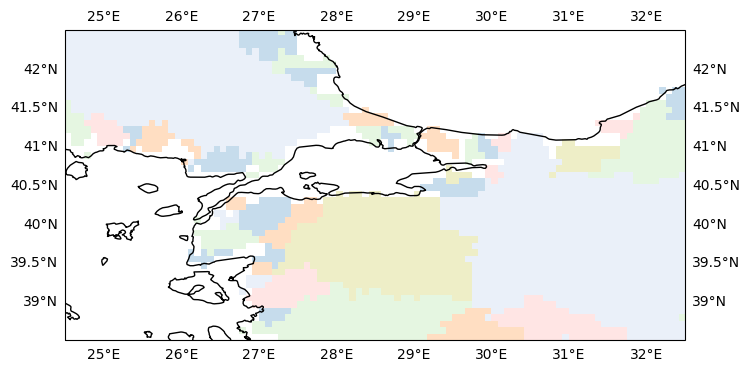

CPU times: user 1.63 s, sys: 201 ms, total: 1.83 s
Wall time: 1.67 s


In [21]:
%time basin_4color(rivnum_cropped, left, right, bottom, top, min_basin_size=5)

In [22]:
def plot_river_4color_city(city_cropped,
                        riv_nxtxy_cropped, rivout_cropped, rivnum_cropped,
                        left, right, bottom, top,
                        projection=ccrs.PlateCarree(),
                        line_color='blue', min_width=0.1, max_width=2.5, 
                        a=2160, b=4320, min_basin_size=5, end_marker_color=(0,0,1,0)):

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], crs=projection)

    H, W = rivnum_cropped.shape
    lat_res = 180.0 / a
    lon_res = 360.0 / b

    # **流域ごとのグリッド数をカウント**
    rivnum_filtered = rivnum_cropped.copy()
    rivnum_filtered[rivnum_filtered == 0] = np.nan
    unique_basins, counts = np.unique(rivnum_filtered[~np.isnan(rivnum_filtered)], return_counts=True)

    # **10グリッド以下の流域をNaNにする**
    small_basins = unique_basins[counts <= min_basin_size]  # 小さい流域番号
    basin_mask = np.isin(rivnum_filtered, small_basins)  # 小さい流域のマスク
    rivnum_filtered[basin_mask] = np.nan  # 10グリッド以下の流域をNaNにする
    
    # **流域マップの描画**
    color_code = ['#8ebad9', '#cbeec4', '#ffbe86', '#d6e2f3', '#ffcbca', '#dddd90']
    color_masked = np.ma.masked_where(rivnum_filtered >= 1e20, rivnum_filtered)
    color_filled = color_masked.filled(-1)
    color_filled = np.nan_to_num(color_filled, nan=-1)
    num_colors, index_dict, cmap = pulp_cmap(color_filled, color_code)
    indexed_data = np.vectorize(get_index)(color_filled, index_dict)
    indexed_data_masked = np.ma.masked_where(indexed_data<0, indexed_data)
    
    im = ax.imshow(indexed_data_masked, 
                   cmap=cmap, transform=projection, extent=[left, right, bottom, top],
                   alpha=0.5)

    # **河川ネットワークの描画**
    mask = ~np.isnan(riv_nxtxy_cropped[..., 0])
    from_y, from_x = np.where(mask)
    to_y, to_x = riv_nxtxy_cropped[mask][:, 0], riv_nxtxy_cropped[mask][:, 1]

    valid_mask = (to_y >= 0) & (to_x >= 0)
    valid_mask &= ~np.isnan(rivnum_filtered[from_y, from_x]) # 小さな流域の河川を除外
    from_y, from_x = from_y[valid_mask], from_x[valid_mask]
    to_y, to_x = to_y[valid_mask], to_x[valid_mask]

    # 河川ごとの流量
    inflow_values = rivout_cropped[from_y, from_x]
    linewidths = np.interp(inflow_values, (inflow_values.min(), inflow_values.max()), (min_width, max_width))

    # 河川の終点
    end_mask = (np.isnan(to_y)) | (np.isnan(to_x)) | ((from_y == to_y) & (from_x == to_x))
    end_y, end_x = from_y[end_mask], from_x[end_mask]  # 終点の座標
    valid_end_mask = ~np.isnan(rivnum_filtered[end_y, end_x])  # 小さい流域の終点を除外
    end_y, end_x = end_y[valid_end_mask], end_x[valid_end_mask]  # フィルタ適用
    end_lats = top - (end_y + 0.5) * lat_res
    end_lons = left + (end_x + 0.5) * lon_res

    # 緯度経度に変換
    lats_from = top - (from_y + 0.5) * lat_res
    lats_to = top - (to_y + 0.5) * lat_res
    lons_from = left + (from_x + 0.5) * lon_res
    lons_to = left + (to_x + 0.5) * lon_res

    points_from = np.column_stack([lons_from, lats_from])
    points_to = np.column_stack([lons_to, lats_to])
    segments = np.stack([points_from, points_to], axis=1)

    lc = LineCollection(segments, colors=line_color, linewidths=linewidths, transform=ccrs.PlateCarree())
    ax.add_collection(lc)
    
    # **河川の終点に〇マークを描写**
    ax.scatter(end_lons, end_lats, color=end_marker_color, s=10, edgecolors='black', transform=ccrs.PlateCarree())

    # city mask
    draw_mask_sotowaku(left, right, bottom, top, city_cropped, ax=ax, sotowaku_color='red', inner_color='red', linewidth=1)

    # 地図の補助情報
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0)

    leftlim, rightlim, bottomlim, toplim = left+1.5, right-1.5, bottom+1.5, top-1.5
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

    plt.show()

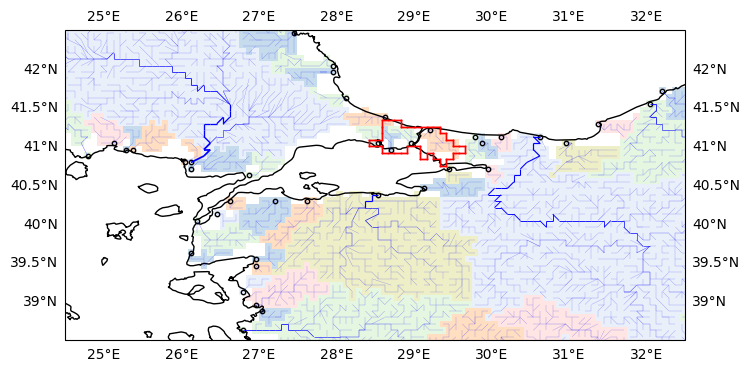

CPU times: user 2.05 s, sys: 334 ms, total: 2.38 s
Wall time: 2.08 s


In [23]:
%time plot_river_4color_city(mask_cropped, riv_nxtxy_cropped, rivout_cropped, rivnum_cropped, left, right, bottom, top, max_width=20)

In [75]:
import math
import numpy as np

def xy2lonlat(y, x, top=90, left=-180, lat_num=2160, lon_num=4320):
    if 0 <= x <= lon_num:
        latcnt = top - y*(180/lat_num)
        loncnt = left + x*(360/lon_num)
    else:
        loncnt = 1e20
        latcnt = 1e20

    return latcnt, loncnt
    
def lonlat_distance(lat_a, lon_a, lat_b, lon_b):
    """" Hybeny's Distance Formula """
    pole_radius = 6356752.314245
    equator_radius = 6378137.0
    radlat_a = math.radians(lat_a)
    radlon_a = math.radians(lon_a)
    radlat_b = math.radians(lat_b)
    radlon_b = math.radians(lon_b)

    lat_dif = radlat_a - radlat_b
    lon_dif = radlon_a - radlon_b
    lat_ave = (radlat_a + radlat_b) / 2

    e2 = (math.pow(equator_radius, 2) - math.pow(pole_radius, 2)) \
            / math.pow(equator_radius, 2)

    w = math.sqrt(1 - e2 * math.pow(math.sin(lat_ave), 2))

    m = equator_radius * (1 - e2) / math.pow(w, 3)

    n = equator_radius / w

    distance = math.sqrt(math.pow(m * lat_dif, 2) \
                + math.pow(n * lon_dif * math.cos(lat_ave), 2))

    return distance / 1000

def create_radius_mask(city_cropped, top, left, search_radius_km=100):
    """
    都市マスクの100km以内のグリッドをマスクとして特定する
    """
    search_mask = np.zeros_like(city_cropped, dtype=bool)
    city_indices = np.where(city_cropped == 1)
    for y, x in zip(city_indices[0], city_indices[1]):
        lat_a, lon_a = xy2lonlat(y, x, top, left)
        for yy in range(city_cropped.shape[0]):
            for xx in range(city_cropped.shape[1]):
                lat_b, lon_b = xy2lonlat(yy, xx, top, left)
                if lonlat_distance(lat_a, lon_a, lat_b, lon_b) <= search_radius_km:
                    search_mask[yy, xx] = True
                    
    return search_mask

def get_downstream_coords(start_coord, riv_nxtxy_cropped):
    """
    指定した座標の下流にある座標を探索
    """
    visited_coords = set()
    target_coord = start_coord

    while target_coord not in visited_coords:
        visited_coords.add(target_coord)
        target_row, target_col = target_coord

        # ① インデックスが有効範囲内かチェック
        if target_row < 0 or target_row >= riv_nxtxy_cropped.shape[0] or \
           target_col < 0 or target_col >= riv_nxtxy_cropped.shape[1]:
            print(f"Error: target_row={target_row}, target_col={target_col} is out of bounds!")
            break  # ループを終了

        # ② 無効な値 (NaN) をチェック
        if np.isnan(target_row) or np.isnan(target_col):
            print("Warning: target_row or target_col is NaN")
            break

        # ③ 次の座標を取得
        next_coord = riv_nxtxy_cropped[target_row, target_col]

        # ④ 次の座標が空なら終了
        if next_coord.size == 0 or next_coord.shape != (2,):
            break

        target_coord = tuple(next_coord)  # NumPy配列をタプルに変換

    return visited_coords

def evaluate_availability(source_list, rivout, city_pop, threshold):
    """
    source_listに基づき、water avaialabilityを累積していく
    """
    accm_ava = 0
    prev_ava = -1
    for y, x in source_list:
        accm_ava += (rivout[y, x] * 1000 / 365) / city_pop
        if accm_ava >= threshold:
            return accm_ava, True

        if abs(accm_ava - prev_ava) < 1e-3:
            break
        prev_ava = accm_ava

    return accm_ava, False

def explore_flow(mask_cropped, rivout_cropped, riv_nxtxy_cropped, city_pop, top, left, search_radius_km=100, threshold=1000):
    """
    流域を探索して適切な水源が得られるまで計算
    """
    search_mask = create_radius_mask(mask_cropped, top, left, search_radius_km=search_radius_km)
    source_list = []

    while True:
        search_rivout = np.where(search_mask, rivout_cropped, 0)
        max_idx = np.unravel_index(np.argmax(search_rivout), search_rivout.shape)

        if max_idx in source_list:
            print(f"no more new sources available: {accm_ava:.2f} liter/day/capita")
            break

        # 下流の探索を実施し、既存のsource_listに含まれるものがあるかチェック
        downstream_coords = get_downstream_coords(max_idx, riv_nxtxy_cropped)
        if any(coord in source_list for coord in downstream_coords):
            search_mask[max_idx] = False  # このポイントを無視
            continue
            
        source_list.append(max_idx)
        accm_ava, success = evaluate_availability(source_list, rivout_cropped, city_pop, threshold=threshold)

        if success:
            print(f"Threshold reached: {accm_ava:.2f} liter/day/capita")
            break

        search_mask[max_idx] = False
        
    return source_list
    
def plot_source(city_cropped,
                        riv_nxtxy_cropped, rivout_cropped, rivnum_cropped,
                        left, right, bottom, top,
                        source_list,  # 追加: source_list の座標
                        projection=ccrs.PlateCarree(),
                        line_color='blue', min_width=0.1, max_width=2.5, 
                        a=2160, b=4320, min_basin_size=5, end_marker_color=(0,0,1,0)):

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], crs=projection)

    H, W = rivnum_cropped.shape
    lat_res = 180.0 / a
    lon_res = 360.0 / b

    # **流域ごとのグリッド数をカウント**
    rivnum_filtered = rivnum_cropped.copy()
    rivnum_filtered[rivnum_filtered == 0] = np.nan
    unique_basins, counts = np.unique(rivnum_filtered[~np.isnan(rivnum_filtered)], return_counts=True)

    # **10グリッド以下の流域をNaNにする**
    small_basins = unique_basins[counts <= min_basin_size]  # 小さい流域番号
    basin_mask = np.isin(rivnum_filtered, small_basins)  # 小さい流域のマスク
    rivnum_filtered[basin_mask] = np.nan  # 10グリッド以下の流域をNaNにする
    
    # **流域マップの描画**
    color_code = ['#8ebad9', '#cbeec4', '#ffbe86', '#d6e2f3', '#ffcbca', '#dddd90']
    color_masked = np.ma.masked_where(rivnum_filtered >= 1e20, rivnum_filtered)
    color_filled = color_masked.filled(-1)
    color_filled = np.nan_to_num(color_filled, nan=-1)
    num_colors, index_dict, cmap = pulp_cmap(color_filled, color_code)
    indexed_data = np.vectorize(get_index)(color_filled, index_dict)
    indexed_data_masked = np.ma.masked_where(indexed_data<0, indexed_data)
    
    im = ax.imshow(indexed_data_masked, 
                   cmap=cmap, transform=projection, extent=[left, right, bottom, top],
                   alpha=0.5)

    # **河川ネットワークの描画**
    mask = ~np.isnan(riv_nxtxy_cropped[..., 0])
    from_y, from_x = np.where(mask)
    to_y, to_x = riv_nxtxy_cropped[mask][:, 0], riv_nxtxy_cropped[mask][:, 1]

    valid_mask = (to_y >= 0) & (to_x >= 0)
    valid_mask &= ~np.isnan(rivnum_filtered[from_y, from_x]) # 小さな流域の河川を除外
    from_y, from_x = from_y[valid_mask], from_x[valid_mask]
    to_y, to_x = to_y[valid_mask], to_x[valid_mask]

    # 河川ごとの流量
    inflow_values = rivout_cropped[from_y, from_x]
    linewidths = np.interp(inflow_values, (inflow_values.min(), inflow_values.max()), (min_width, max_width))

    # 河川の終点
    end_mask = (np.isnan(to_y)) | (np.isnan(to_x)) | ((from_y == to_y) & (from_x == to_x))
    end_y, end_x = from_y[end_mask], from_x[end_mask]  # 終点の座標
    valid_end_mask = ~np.isnan(rivnum_filtered[end_y, end_x])  # 小さい流域の終点を除外
    end_y, end_x = end_y[valid_end_mask], end_x[valid_end_mask]  # フィルタ適用
    end_lats = top - (end_y + 0.5) * lat_res
    end_lons = left + (end_x + 0.5) * lon_res

    # 緯度経度に変換
    lats_from = top - (from_y + 0.5) * lat_res
    lats_to = top - (to_y + 0.5) * lat_res
    lons_from = left + (from_x + 0.5) * lon_res
    lons_to = left + (to_x + 0.5) * lon_res

    points_from = np.column_stack([lons_from, lats_from])
    points_to = np.column_stack([lons_to, lats_to])
    segments = np.stack([points_from, points_to], axis=1)

    lc = LineCollection(segments, colors=line_color, linewidths=linewidths, transform=ccrs.PlateCarree())
    ax.add_collection(lc)
    
    # **河川の終点に〇マークを描写**
    ax.scatter(end_lons, end_lats, color=end_marker_color, s=10, edgecolors='black', transform=ccrs.PlateCarree())

    # **source_list の座標をX印でプロット**
    if source_list:
        source_y, source_x = zip(*source_list)  # 座標リストを分解
        source_lats = top - (np.array(source_y) + 0.5) * lat_res
        source_lons = left + (np.array(source_x) + 0.5) * lon_res

        ax.scatter(source_lons, source_lats, color='green', marker='x', s=20, linewidths=1, transform=ccrs.PlateCarree())

    # city mask
    draw_mask_sotowaku(left, right, bottom, top, city_cropped, ax=ax, sotowaku_color='red', inner_color='red', linewidth=1)

    # 地図の補助情報
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0)

    leftlim, rightlim, bottomlim, toplim = left+1.5, right-1.5, bottom+1.5, top-1.5
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

    plt.show()

Error: target_row=-9223372036854775808, target_col=-9223372036854775808 is out of bounds!
no more new sources available: 3800.54 liter/day/capita
CPU times: user 1.34 s, sys: 9.7 ms, total: 1.35 s
Wall time: 1.35 s


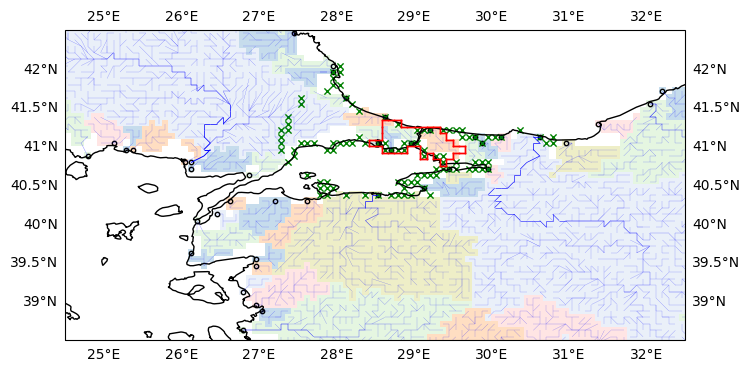

CPU times: user 1.9 s, sys: 368 ms, total: 2.26 s
Wall time: 1.95 s


In [76]:
%time source_list = explore_flow(mask_cropped, rivout_cropped, riv_nxtxy_cropped, city_pop, top, left, search_radius_km=100, threshold=4000)
%time plot_source(mask_cropped, riv_nxtxy_cropped, rivout_cropped, rivnum_cropped, left, right, bottom, top, source_list, max_width=10)

In [127]:
import math
import numpy as np

# elevation
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
elv_path = f'{h08dir}/global_city/dat/elv_min_/elevtn.CAMA.gl5'
elv = np.fromfile(elv_path, dtype='float32').reshape(2160, 4320) 
elv_cropped = elv[upperindex:lowerindex, leftindex:rightindex]

# city water inlet
camadir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity'
prf_path = f"{camadir}/dat/cty_prf_/prf_clrd0000.gl5"
prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
prf_cropped = prf[upperindex:lowerindex, leftindex:rightindex]
prf_coords = np.where(prf_cropped==city_num)

def xy2lonlat(y, x, top=90, left=-180, lat_num=2160, lon_num=4320):
    if 0 <= x <= lon_num:
        latcnt = top - y*(180/lat_num)
        loncnt = left + x*(360/lon_num)
    else:
        loncnt = 1e20
        latcnt = 1e20

    return latcnt, loncnt
    
def lonlat_distance(lat_a, lon_a, lat_b, lon_b):
    """" Hybeny's Distance Formula """
    pole_radius = 6356752.314245
    equator_radius = 6378137.0
    radlat_a = math.radians(lat_a)
    radlon_a = math.radians(lon_a)
    radlat_b = math.radians(lat_b)
    radlon_b = math.radians(lon_b)

    lat_dif = radlat_a - radlat_b
    lon_dif = radlon_a - radlon_b
    lat_ave = (radlat_a + radlat_b) / 2

    e2 = (math.pow(equator_radius, 2) - math.pow(pole_radius, 2)) \
            / math.pow(equator_radius, 2)

    w = math.sqrt(1 - e2 * math.pow(math.sin(lat_ave), 2))

    m = equator_radius * (1 - e2) / math.pow(w, 3)

    n = equator_radius / w

    distance = math.sqrt(math.pow(m * lat_dif, 2) \
                + math.pow(n * lon_dif * math.cos(lat_ave), 2))

    return distance / 1000

def create_radius_mask(city_cropped, top, left, search_radius_km=100):
    """
    都市マスクの100km以内のグリッドをマスクとして特定する
    """
    search_mask = np.zeros_like(city_cropped, dtype=bool)
    city_indices = np.where(city_cropped == 1)
    for y, x in zip(city_indices[0], city_indices[1]):
        lat_a, lon_a = xy2lonlat(y, x, top, left)
        for yy in range(city_cropped.shape[0]):
            for xx in range(city_cropped.shape[1]):
                lat_b, lon_b = xy2lonlat(yy, xx, top, left)
                if lonlat_distance(lat_a, lon_a, lat_b, lon_b) <= search_radius_km:
                    search_mask[yy, xx] = True
                    
    return search_mask

def get_downstream_coords(start_coord, riv_nxtxy_cropped):
    """
    指定した座標の下流にある座標を探索
    """
    visited_coords = set()
    target_coord = start_coord

    while target_coord not in visited_coords:
        visited_coords.add(target_coord)
        target_row, target_col = target_coord

        # ① インデックスが有効範囲内かチェック
        if target_row < 0 or target_row >= riv_nxtxy_cropped.shape[0] or \
           target_col < 0 or target_col >= riv_nxtxy_cropped.shape[1]:
            print(f"Error: target_row={target_row}, target_col={target_col} is out of bounds!")
            break  # ループを終了

        # ② 無効な値 (NaN) をチェック
        if np.isnan(target_row) or np.isnan(target_col):
            print("Warning: target_row or target_col is NaN")
            break

        # ③ 次の座標を取得
        next_coord = riv_nxtxy_cropped[target_row, target_col]

        # ④ 次の座標が空なら終了
        if next_coord.size == 0 or next_coord.shape != (2,):
            break

        target_coord = tuple(next_coord)  # NumPy配列をタプルに変換

    return visited_coords

def evaluate_availability(source_list, rivout, city_pop, threshold):
    """
    source_listに基づき、water avaialabilityを累積していく
    """
    accm_ava = 0
    prev_ava = -1
    for y, x in source_list:
        accm_ava += (rivout[y, x] * 1000 / 365) / city_pop
        if accm_ava >= threshold:
            return accm_ava, True

        if abs(accm_ava - prev_ava) < 1e-3:
            break
        prev_ava = accm_ava

    return accm_ava, False

def explore_flow(mask_cropped, rivnum_cropped, rivout_cropped, riv_nxtxy_cropped, elv_cropped, inlet_coords, city_pop, top, left, min_basin_size=5, add_rate=0.1, search_radius_km=100, threshold=1000):
    """
    流域を探索して適切な水源が得られるまで計算
    """
    # 探索する範囲
    search_mask = create_radius_mask(mask_cropped, top, left, search_radius_km=search_radius_km)
    
    # 小さい流域をマスクから除外
    unique_basins, counts = np.unique(rivnum_cropped, return_counts=True)
    small_basins = unique_basins[counts <= min_basin_size]
    small_basin_mask = np.isin(rivnum_cropped, small_basins)
    search_mask[small_basin_mask] = False

    # 標高データの最低値を取得し、それよりも高い地点を選択
    elv_min = np.min(elv_cropped[inlet_coords])
    search_mask &= (elv_cropped > elv_min) & (mask_cropped == 0)

    # city water inletを追加する
    source_list = list(zip(inlet_coords[0], inlet_coords[1]))
    
    while True:
        # 累積流量の初期値を計算
        total_flow = np.sum([rivout_cropped[y, x] for y, x in source_list])
        search_rivout = np.where(search_mask, rivout_cropped, 0)
        max_idx = np.unravel_index(np.argmax(search_rivout), search_rivout.shape)

        max_flow = search_rivout[max_idx]
        if max_flow < add_rate * total_flow:
            print(f"Stopping search: max_flow ({max_flow * 1000 / 365 / city_pop}) is less than {add_rate*100}% of total_flow ({total_flow * 1000 / 365/ city_pop})")
            break
            
        if max_idx in source_list:
            print(f"no more new sources available: {accm_ava:.2f} liter/day/capita")
            break

        # 下流の探索を実施し、既存のsource_listに含まれるものがあるかチェック
        downstream_coords = get_downstream_coords(max_idx, riv_nxtxy_cropped)
        if any(coord in source_list for coord in downstream_coords):
            search_mask[max_idx] = False  # このポイントを無視
            continue
            
        source_list.append(max_idx)
        accm_ava, success = evaluate_availability(source_list, rivout_cropped, city_pop, threshold=threshold)

        if success:
            print(f"Threshold reached: {accm_ava:.2f} liter/day/capita")
            break

        search_mask[max_idx] = False
        
    return accm_ava, source_list
    
def plot_source(city_cropped,
                        riv_nxtxy_cropped, rivout_cropped, rivnum_cropped,
                        left, right, bottom, top,
                        source_list,  # 追加: source_list の座標
                        projection=ccrs.PlateCarree(),
                        line_color='blue', min_width=0.1, max_width=2.5, 
                        a=2160, b=4320, min_basin_size=5, end_marker_color=(0,0,1,0)):

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], crs=projection)

    H, W = rivnum_cropped.shape
    lat_res = 180.0 / a
    lon_res = 360.0 / b

    # **流域ごとのグリッド数をカウント**
    rivnum_filtered = rivnum_cropped.copy()
    rivnum_filtered[rivnum_filtered == 0] = np.nan
    unique_basins, counts = np.unique(rivnum_filtered[~np.isnan(rivnum_filtered)], return_counts=True)

    # **10グリッド以下の流域をNaNにする**
    small_basins = unique_basins[counts <= min_basin_size]  # 小さい流域番号
    basin_mask = np.isin(rivnum_filtered, small_basins)  # 小さい流域のマスク
    rivnum_filtered[basin_mask] = np.nan  # 10グリッド以下の流域をNaNにする
    
    # **流域マップの描画**
    color_code = ['#8ebad9', '#cbeec4', '#ffbe86', '#d6e2f3', '#ffcbca', '#dddd90']
    color_masked = np.ma.masked_where(rivnum_filtered >= 1e20, rivnum_filtered)
    color_filled = color_masked.filled(-1)
    color_filled = np.nan_to_num(color_filled, nan=-1)
    num_colors, index_dict, cmap = pulp_cmap(color_filled, color_code)
    indexed_data = np.vectorize(get_index)(color_filled, index_dict)
    indexed_data_masked = np.ma.masked_where(indexed_data<0, indexed_data)
    
    im = ax.imshow(indexed_data_masked, 
                   cmap=cmap, transform=projection, extent=[left, right, bottom, top],
                   alpha=0.5)

    # **河川ネットワークの描画**
    mask = ~np.isnan(riv_nxtxy_cropped[..., 0])
    from_y, from_x = np.where(mask)
    to_y, to_x = riv_nxtxy_cropped[mask][:, 0], riv_nxtxy_cropped[mask][:, 1]

    valid_mask = (to_y >= 0) & (to_x >= 0)
    valid_mask &= ~np.isnan(rivnum_filtered[from_y, from_x]) # 小さな流域の河川を除外
    from_y, from_x = from_y[valid_mask], from_x[valid_mask]
    to_y, to_x = to_y[valid_mask], to_x[valid_mask]

    # 河川ごとの流量
    inflow_values = rivout_cropped[from_y, from_x]
    linewidths = np.interp(inflow_values, (inflow_values.min(), inflow_values.max()), (min_width, max_width))

    # 河川の終点
    end_mask = (np.isnan(to_y)) | (np.isnan(to_x)) | ((from_y == to_y) & (from_x == to_x))
    end_y, end_x = from_y[end_mask], from_x[end_mask]  # 終点の座標
    valid_end_mask = ~np.isnan(rivnum_filtered[end_y, end_x])  # 小さい流域の終点を除外
    end_y, end_x = end_y[valid_end_mask], end_x[valid_end_mask]  # フィルタ適用
    end_lats = top - (end_y + 0.5) * lat_res
    end_lons = left + (end_x + 0.5) * lon_res

    # 緯度経度に変換
    lats_from = top - (from_y + 0.5) * lat_res
    lats_to = top - (to_y + 0.5) * lat_res
    lons_from = left + (from_x + 0.5) * lon_res
    lons_to = left + (to_x + 0.5) * lon_res

    points_from = np.column_stack([lons_from, lats_from])
    points_to = np.column_stack([lons_to, lats_to])
    segments = np.stack([points_from, points_to], axis=1)

    lc = LineCollection(segments, colors=line_color, linewidths=linewidths, transform=ccrs.PlateCarree())
    ax.add_collection(lc)
    
    # **河川の終点に〇マークを描写**
    ax.scatter(end_lons, end_lats, color=end_marker_color, s=10, edgecolors='black', transform=ccrs.PlateCarree())

    # **source_list の座標をX印でプロット**
    if source_list:
        source_y, source_x = zip(*source_list)  # 座標リストを分解
        source_lats = top - (np.array(source_y) + 0.5) * lat_res
        source_lons = left + (np.array(source_x) + 0.5) * lon_res

        ax.scatter(source_lons, source_lats, color='green', marker='x', s=20, linewidths=1, transform=ccrs.PlateCarree())

    # city mask
    draw_mask_sotowaku(left, right, bottom, top, city_cropped, ax=ax, sotowaku_color='red', inner_color='red', linewidth=1)

    # 地図の補助情報
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0)

    leftlim, rightlim, bottomlim, toplim = left+1.5, right-1.5, bottom+1.5, top-1.5
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

    plt.show()

Threshold reached: 4075.64 liter/day/capita
CPU times: user 1.42 s, sys: 9.59 ms, total: 1.43 s
Wall time: 1.42 s


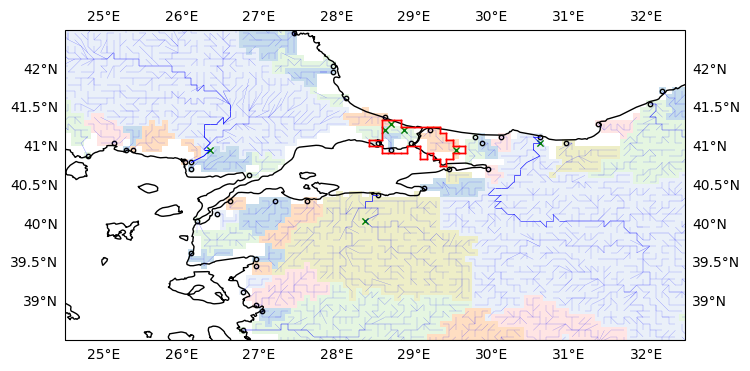

CPU times: user 1.98 s, sys: 369 ms, total: 2.35 s
Wall time: 2.04 s
4075.6372225404157 liter/per/capita


In [131]:
%time accm_ava, source_list = explore_flow(mask_cropped, rivnum_cropped, rivout_cropped, riv_nxtxy_cropped, elv_cropped, prf_coords, city_pop, top, left, add_rate=0.1, search_radius_km=200, threshold=4000)
%time plot_source(mask_cropped, riv_nxtxy_cropped, rivout_cropped, rivnum_cropped, left, right, bottom, top, source_list, max_width=10)
print(f"{accm_ava} liter/per/capita")

In [177]:
# elevation
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
elv_path = f'{h08dir}/global_city/dat/elv_min_/elevtn.CAMA.gl5'
elv = np.fromfile(elv_path, dtype='float32').reshape(2160, 4320) 
elv_cropped = elv[upperindex:lowerindex, leftindex:rightindex]

# city water inlet
camadir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity'
prf_path = f"{camadir}/dat/cty_prf_/prf_clrd0000.gl5"
prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
prf_cropped = prf[upperindex:lowerindex, leftindex:rightindex]
prf_coords = np.where(prf_cropped==city_num)

def xy2lonlat(y, x, top=90, left=-180, lat_num=2160, lon_num=4320):
    if 0 <= x <= lon_num:
        latcnt = top - y*(180/lat_num)
        loncnt = left + x*(360/lon_num)
    else:
        loncnt = 1e20
        latcnt = 1e20

    return latcnt, loncnt
    
def lonlat_distance(lat_a, lon_a, lat_b, lon_b):
    """" Hybeny's Distance Formula """
    pole_radius = 6356752.314245
    equator_radius = 6378137.0
    radlat_a = math.radians(lat_a)
    radlon_a = math.radians(lon_a)
    radlat_b = math.radians(lat_b)
    radlon_b = math.radians(lon_b)

    lat_dif = radlat_a - radlat_b
    lon_dif = radlon_a - radlon_b
    lat_ave = (radlat_a + radlat_b) / 2

    e2 = (math.pow(equator_radius, 2) - math.pow(pole_radius, 2)) \
            / math.pow(equator_radius, 2)

    w = math.sqrt(1 - e2 * math.pow(math.sin(lat_ave), 2))

    m = equator_radius * (1 - e2) / math.pow(w, 3)

    n = equator_radius / w

    distance = math.sqrt(math.pow(m * lat_dif, 2) \
                + math.pow(n * lon_dif * math.cos(lat_ave), 2))

    return distance / 1000

def create_radius_mask(city_cropped, top, left, search_radius_km=100):
    """
    都市マスクの100km以内のグリッドをマスクとして特定する
    """
    search_mask = np.zeros_like(city_cropped, dtype=bool)
    city_indices = np.where(city_cropped == 1)
    for y, x in zip(city_indices[0], city_indices[1]):
        lat_a, lon_a = xy2lonlat(y, x, top, left)
        for yy in range(city_cropped.shape[0]):
            for xx in range(city_cropped.shape[1]):
                lat_b, lon_b = xy2lonlat(yy, xx, top, left)
                if lonlat_distance(lat_a, lon_a, lat_b, lon_b) <= search_radius_km:
                    search_mask[yy, xx] = True
                    
    return search_mask

def get_downstream_coords(start_coord, riv_nxtxy_cropped):
    """
    指定した座標の下流にある座標を探索
    """
    visited_coords = set()
    target_coord = start_coord

    while target_coord not in visited_coords:
        visited_coords.add(target_coord)
        target_row, target_col = target_coord

        # ① インデックスが有効範囲内かチェック
        if target_row < 0 or target_row >= riv_nxtxy_cropped.shape[0] or \
           target_col < 0 or target_col >= riv_nxtxy_cropped.shape[1]:
            print(f"Error: target_row={target_row}, target_col={target_col} is out of bounds!")
            break  # ループを終了

        # ② 無効な値 (NaN) をチェック
        if np.isnan(target_row) or np.isnan(target_col):
            print("Warning: target_row or target_col is NaN")
            break

        # ③ 次の座標を取得
        next_coord = riv_nxtxy_cropped[target_row, target_col]

        # ④ 次の座標が空なら終了
        if next_coord.size == 0 or next_coord.shape != (2,):
            break

        target_coord = tuple(next_coord)  # NumPy配列をタプルに変換

    return visited_coords

def evaluate_availability(source_list, rivout, city_pop, threshold):
    """
    source_listに基づき、water avaialabilityを累積していく
    """
    accm_ava = 0
    prev_ava = -1
    for y, x in source_list:
        accm_ava += (rivout[y, x] * 1000 / 365) / city_pop
        if accm_ava >= threshold:
            return accm_ava, True

        if abs(accm_ava - prev_ava) < 1e-3:
            break
        prev_ava = accm_ava

    return accm_ava, False

def explore_flow(mask_cropped, rivnum_cropped, rivout_cropped, riv_nxtxy_cropped, elv_cropped, inlet_coords, city_pop, top, left, min_basin_size=5, add_rate=0.1, search_radius_km=100, threshold=1000):
    """
    流域を探索して適切な水源が得られるまで計算
    """
    # 探索する範囲
    search_mask = create_radius_mask(mask_cropped, top, left, search_radius_km=search_radius_km)
    
    # 小さい流域をマスクから除外
    unique_basins, counts = np.unique(rivnum_cropped, return_counts=True)
    small_basins = unique_basins[counts <= min_basin_size]
    small_basin_mask = np.isin(rivnum_cropped, small_basins)
    search_mask[small_basin_mask] = False

    # 標高データの最低値を取得し、それよりも高い地点を選択
    elv_min = np.min(elv_cropped[inlet_coords])
    search_mask &= (elv_cropped > elv_min) & (mask_cropped == 0)

    # city water inletを追加する
    source_list = list(zip(inlet_coords[0], inlet_coords[1]))
    
    while True:
        # 累積流量の初期値を計算
        total_flow = np.sum([rivout_cropped[y, x] for y, x in source_list])
        search_rivout = np.where(search_mask, rivout_cropped, 0)
        max_idx = np.unravel_index(np.argmax(search_rivout), search_rivout.shape)

        max_flow = search_rivout[max_idx]
        if max_flow < add_rate * total_flow:
            print(f"Stopping search: max_flow ({max_flow * 1000 / 365 / city_pop}) is less than {add_rate*100}% of total_flow ({total_flow * 1000 / 365/ city_pop})")
            break
            
        if max_idx in source_list:
            print(f"no more new sources available: {accm_ava:.2f} liter/day/capita")
            break

        # 下流の探索を実施し、既存のsource_listに含まれるものがあるかチェック
        downstream_coords = get_downstream_coords(max_idx, riv_nxtxy_cropped)
        if any(coord in source_list for coord in downstream_coords):
            search_mask[max_idx] = False  # このポイントを無視
            continue
            
        source_list.append(max_idx)
        accm_ava, success = evaluate_availability(source_list, rivout_cropped, city_pop, threshold=threshold)

        if success:
            print(f"Threshold reached: {accm_ava:.2f} liter/day/capita")
            break

        search_mask[max_idx] = False
        
    return accm_ava, source_list
    
def plot_source(city_cropped,
                        riv_nxtxy_cropped, rivout_cropped, rivnum_cropped, city_pop,
                        left, right, bottom, top,
                        source_list,  # 追加: source_list の座標
                        projection=ccrs.PlateCarree(),
                        line_color='blue', min_width=0.1, max_width=2.5, 
                        a=2160, b=4320, min_basin_size=5, end_marker_color=(0,0,1,0)):

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], crs=projection)

    H, W = rivnum_cropped.shape
    lat_res = 180.0 / a
    lon_res = 360.0 / b

    # **流域ごとのグリッド数をカウント**
    rivnum_filtered = rivnum_cropped.copy()
    rivnum_filtered[rivnum_filtered == 0] = np.nan
    unique_basins, counts = np.unique(rivnum_filtered[~np.isnan(rivnum_filtered)], return_counts=True)

    # **10グリッド以下の流域をNaNにする**
    small_basins = unique_basins[counts <= min_basin_size]  # 小さい流域番号
    basin_mask = np.isin(rivnum_filtered, small_basins)  # 小さい流域のマスク
    rivnum_filtered[basin_mask] = np.nan  # 10グリッド以下の流域をNaNにする
    
    # **流域マップの描画**
    color_code = ['#8ebad9', '#cbeec4', '#ffbe86', '#d6e2f3', '#ffcbca', '#dddd90']
    color_masked = np.ma.masked_where(rivnum_filtered >= 1e20, rivnum_filtered)
    color_filled = color_masked.filled(-1)
    color_filled = np.nan_to_num(color_filled, nan=-1)
    num_colors, index_dict, cmap = pulp_cmap(color_filled, color_code)
    indexed_data = np.vectorize(get_index)(color_filled, index_dict)
    indexed_data_masked = np.ma.masked_where(indexed_data<0, indexed_data)
    
    im = ax.imshow(indexed_data_masked, 
                   cmap=cmap, transform=projection, extent=[left, right, bottom, top],
                   alpha=0.5)

    # **河川ネットワークの描画**
    mask = ~np.isnan(riv_nxtxy_cropped[..., 0])
    from_y, from_x = np.where(mask)
    to_y, to_x = riv_nxtxy_cropped[mask][:, 0], riv_nxtxy_cropped[mask][:, 1]

    valid_mask = (to_y >= 0) & (to_x >= 0)
    valid_mask &= ~np.isnan(rivnum_filtered[from_y, from_x]) # 小さな流域の河川を除外
    from_y, from_x = from_y[valid_mask], from_x[valid_mask]
    to_y, to_x = to_y[valid_mask], to_x[valid_mask]

    # 河川ごとの流量
    inflow_values = rivout_cropped[from_y, from_x]
    linewidths = np.interp(inflow_values, (inflow_values.min(), inflow_values.max()), (min_width, max_width))

    # 河川の終点
    end_mask = (np.isnan(to_y)) | (np.isnan(to_x)) | ((from_y == to_y) & (from_x == to_x))
    end_y, end_x = from_y[end_mask], from_x[end_mask]  # 終点の座標
    valid_end_mask = ~np.isnan(rivnum_filtered[end_y, end_x])  # 小さい流域の終点を除外
    end_y, end_x = end_y[valid_end_mask], end_x[valid_end_mask]  # フィルタ適用
    end_lats = top - (end_y + 0.5) * lat_res
    end_lons = left + (end_x + 0.5) * lon_res

    # 緯度経度に変換
    lats_from = top - (from_y + 0.5) * lat_res
    lats_to = top - (to_y + 0.5) * lat_res
    lons_from = left + (from_x + 0.5) * lon_res
    lons_to = left + (to_x + 0.5) * lon_res

    points_from = np.column_stack([lons_from, lats_from])
    points_to = np.column_stack([lons_to, lats_to])
    segments = np.stack([points_from, points_to], axis=1)

    lc = LineCollection(segments, colors=line_color, linewidths=linewidths, transform=ccrs.PlateCarree())
    ax.add_collection(lc)
    
    # **河川の終点に〇マークを描写**
    #ax.scatter(end_lons, end_lats, color=end_marker_color, s=10, edgecolors='black', transform=ccrs.PlateCarree())

    # **source_list の座標を X 印でプロットし、矢印付きの番号と流量を表示**
    if source_list:
        source_y, source_x = zip(*source_list)  # 座標リストを分解
        source_lats = top - (np.array(source_y) + 0.5) * lat_res
        source_lons = left + (np.array(source_x) + 0.5) * lon_res
    
        #ax.scatter(source_lons, source_lats, color='green', marker='x', s=20, linewidths=1, transform=ccrs.PlateCarree())
        ax.scatter(source_lons, source_lats, color=end_marker_color, s=10, edgecolors='black', transform=ccrs.PlateCarree())
    
        # 矢印のオフセット（少しずつ異なる方向にずらす）
        #offsets = [(0.05, 0.05), (-0.05, 0.05), (0.05, -0.05), (-0.05, -0.05)]
        offsize = 1.0
        offsets = [(offsize, offsize), (-offsize, offsize), (offsize, -offsize), (-offsize, -offsize)]
        
        for i, (y, x) in enumerate(source_list, start=1):
            lat = top - (y + 0.5) * lat_res
            lon = left + (x + 0.5) * lon_res
            flow = rivout_cropped[y, x] * 1000 / 365 / city_pop  # 流量を取得
    
            # 異なる方向にずらすためのオフセット
            dx, dy = offsets[i % len(offsets)]
            text_lon = lon + dx
            text_lat = lat + dy
    
            ax.annotate(
                f"{i}\n{int(flow)}L/day",
                xy=(lon, lat), xytext=(text_lon, text_lat),
                fontsize=9, color="black",
                arrowprops=dict(arrowstyle="->", lw=1.0, color="black"),
                ha='center', va='center',
                transform=ax.transData
            )
        
    # city mask
    draw_mask_sotowaku(left, right, bottom, top, city_cropped, ax=ax, sotowaku_color='red', inner_color='red', linewidth=1)

    # 地図の補助情報
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0)

    leftlim, rightlim, bottomlim, toplim = left+1.5, right-1.5, bottom+1.5, top-1.5
    ax.set_xlim(leftlim, rightlim)
    ax.set_ylim(bottomlim, toplim)

    plt.show()

Threshold reached: 1404.22 liter/day/capita
CPU times: user 1.34 s, sys: 0 ns, total: 1.34 s
Wall time: 1.34 s


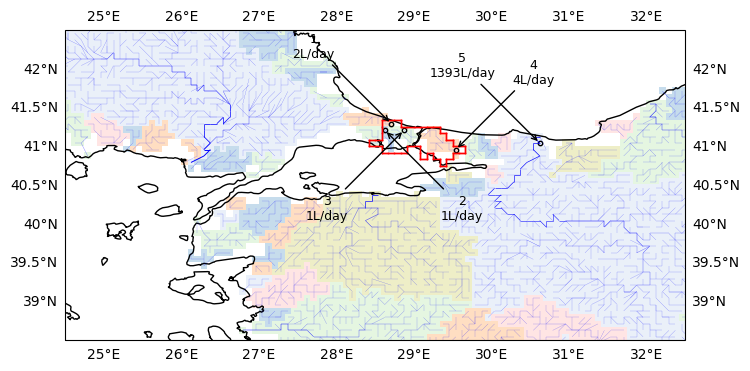

CPU times: user 2.02 s, sys: 369 ms, total: 2.38 s
Wall time: 2.08 s
1404.217937854917 liter/per/capita


In [178]:
%time accm_ava, source_list = explore_flow(mask_cropped, rivnum_cropped, rivout_cropped, riv_nxtxy_cropped, elv_cropped, prf_coords, city_pop, top, left, add_rate=0.1, search_radius_km=100, threshold=1000)
%time plot_source(mask_cropped, riv_nxtxy_cropped, rivout_cropped, rivnum_cropped, city_pop, left, right, bottom, top, source_list, max_width=10)
print(f"{accm_ava} liter/per/capita")